#### **Infos importantes**
Voici les principes retenus pour la recherche de chaque seuil : 
- **Seuil bas** 
1. Utiliser un dataset d'images aléatoires qui ne contiennent pas d'armes à feu(Open Images [format url] ou DUTS [format jpg] par exemple) 
2. Appliquer Basegun sur chacune et retenir les indices de fiabilité pour chaque image
3. Statistiques pour déterminer quels seuils (bas) permettraient de retirer 75 à 95% des images
4. Le choix du seuil bas se fera ensuite en fonction d'autres informations...

- **Seuil haut** 
1. Utiliser le fichier .csv des probabilités calculées spar Basegun durant sa phase d'entrainement
2. A partir de ces probas, statistiques pour déterminer : 
    - Le seuil haut (il doit rejeter un maximum de mauvaises prédictions du modèle tout en évitant de rejeter les prédictions correctes associées à des indices de fiabilité peu élévés)
    - Le seuil bas (il doit à tout prix éviter de rejeter des prédictions correctes, car le seuil bas est le seuil en dessous duquel on considère qu'il n'y a pas d'arme sur l'image)

# Table des matières
1. **[Initialisation](#init)**
 - [Importer les modules](#import)
 - [Charger les fonctions d'image processing et de model building](#load)


2. **[Télécharger les datasets de tests](#download)**
 - [Dataset d'URL d'images : Open Images](#openimages)
 - [Dataset d'images : DUTS](#duts)


3. **[Recherche des seuils](#lookfor)**
 - [Charger la fonction](#function)
 - [Lancer l'analyse](#go)

# **1. Initialisation <a name='init'/>**

## A) Importer les modules <a name='import'/>

In [3]:
# !pip install progressbar

In [12]:
import os
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from math import sqrt, pow

from PIL import Image
from torch import Tensor
import pandas as pd
import torch
import torch.onnx
import torchvision.models as Model

import requests
import shutil
import progressbar
import zipfile

## B) Charger les fonctions d'image processing et de model building <a name='load'/>

In [13]:
CLASSES = ['autre_epaule', 'autre_pistolet', 'epaule_a_levier_sous_garde',
        'epaule_a_percussion_silex', 'epaule_a_pompe', 'epaule_a_un_coup', 'epaule_a_verrou',
        'pistolet_a_percussion_silex', 'pistolet_semi_auto_moderne', 'revolver']

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class ConvertRgb(object):
    def __init__(self):
        pass

    def __call__(self, image):
        if image.mode != 'RGB':
            image = image.convert('RGB')
        return image


class Rescale(object):
    """Rescale the image in a sample to a given size while keeping ratio
    Args:
        output_size (int): Desired output size. The largest of image edges is matched
            to output_size keeping aspect ratio the same.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size

    def __call__(self, image):
        try:
            w, h = image.size
        except: w, h = image.shape[:2]
        if w > h:
            new_h, new_w = self.output_size * h / w, self.output_size
        else:
            new_h, new_w = self.output_size, self.output_size * w / h
        new_h, new_w = int(new_h), int(new_w)
        return transforms.functional.resize(image, (new_h, new_w))


class RandomPad(object):
    """Pad an image to reach a given size
    Args:
        output_size (int): Desired output size. We pad all edges
                        symmetrically to reach a size x size image.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size

    def __call__(self, image):
        try:
            w, h = image.size
        except: 
            w, h = image.shape[:2]
        pads = {'horiz': [self.output_size - w,0,0],
        'vert': [self.output_size - h,0,0]}
        if pads['horiz'][0] >= 0 and pads['vert'][0] >= 0:
            for direction in ['horiz', 'vert'] :
                pads[direction][1] = pads[direction][0] // 2
                if pads[direction][0] % 2 == 1: # if the size to pad is odd, add a random +1 on one side
                    pads[direction][1] += np.random.randint(0,1)
                pads[direction][2] = pads[direction][0] - pads[direction][1]

            return transforms.functional.pad(image,
                [pads['horiz'][1], pads['vert'][1], pads['horiz'][2], pads['vert'][2]],
                fill = int(np.random.choice([0, 255])) # border randomly white or black
            )
        else:
            return image
        
        
def build_model(model: Model) -> Model:
    # freeze first layers
    for param in model.parameters():
        param.requires_grad = False
    # Parameters of newly constructed modules have requires_grad=True by default
    num_ftrs = model.classifier[1].in_features
    # to try later : add batch normalization and dropout
    model.classifier[1] = torch.nn.Linear(num_ftrs, len(CLASSES))
    model = model.to(device)
    return model


def load_model_inference(state_dict_path: str, MODEL_TORCH, INPUT_SIZE) -> Model:
    model = build_model(MODEL_TORCH())
    # Initialize model with the pretrained weights
    model.load_state_dict(torch.load(state_dict_path, map_location=device)['model_state_dict'])
    model.to(device)
    # set the model to inference mode
    model.eval()
    return model


def test_image(model, path, show_images, loader):
    im = Image.open(path)
    image = loader(im).float()
    image = image.unsqueeze(0).to(device)
    output = model(image)
    probs = torch.nn.functional.softmax(output, dim=1).detach().numpy()[0]
    res = [(CLASSES[i], round(probs[i]*100,2)) for i in range(len(CLASSES))]
    res.sort(key=lambda x:x[1], reverse=True)
    im = im.resize((300,int(300*im.size[1]/im.size[0])))
    if show_images:
        display(im)
    return res[0][1]

---

# **2. Télécharger les datasets de tests <a name='download'/>**

## A) Dataset d'URL d'images : Open Images <a name='openimages'/>
Ce dataset contient des liens vers des images : il est donc très léger (10 Mo)

In [6]:
url = "https://storage.googleapis.com/cvdf-datasets/oid/open-images-dataset-test.tsv"
r = requests.get(url)
with open("openim.tsv","wb") as f: 
    f.write(r.content)

## B) Dataset d'images : DUTS <a name='duts'/>
10 000 images - 250 Mo (Temps de téléchargement + unzip = 2min)

In [7]:
url = "http://saliencydetection.net/duts/download/DUTS-TR.zip"
r = requests.get(url)
try:
    with open("DUTS-TR.zip","wb") as f: 
        f.write(r.content)
    with zipfile.ZipFile("DUTS-TR.zip","r") as f:
        f.extractall()
    os.remove("DUTS-TR.zip")
except:
    pass

---

# **3. Recherche des seuils <a name='lookfor'/>**

## A) Charger la fonction <a name='function'/>

### **1) Seuil bas**

In [14]:
def low_threshold(MODEL_TORCH, INPUT_SIZE, loader, model_name, path_test_images=None, images_as_urls=True, nb_test_images=100, show_images=False):
    """ Recherche le seuil bas de Basegun, qui dira que l'image donnée à Basegun n'est probablement pas une photo d'armes à feu
    Args:
        MODEL_TORCH (str): surnom du modèle choisi pour construire Basegun
        UNPUT_SIZE (int): taille de l'input associé au modèle choisi
        loader (transforms.Compose): permet de pre-process chaque image du dataset
        model_name (str): nom du modèle qui sera utilisé pour construire Basegun
        path_test_images (str): path vers des images random à utiliser pour trouver le seuil bas --facultatif--
        images_as_url (bool): le dataset à utiliser pour le seuil bas est Open Images (True car url d'images) ou DUTS (False)
        nb_test_images (int): nombre d'images à utiliser pour calculer le seuil bas 
        show_images (bool): affiche les images inférées pendant la recherche du seuil bas ainsi que leur propa calculée par Basegun
    Returns:
        possible_low (dict): dictionnaire contenant plusieurs valeurs possibles de seuil bas et des infos relatives : elles permettront de choisir un meilleur seuil haut
    """         
    
    path_model = f"/workspace/models/{model_name}/{model_name}.pth"
    model = load_model_inference(path_model, MODEL_TORCH, INPUT_SIZE)
    probas = []
    
    if not images_as_urls and path_test_images!=None: # just to make sure our progressbar will be have the good number of pins
        l = len(os.listdir(path_test_images))
        if nb_test_images > l:
            nb_test_images = l
            print(nb_test_images)
            
    if not show_images: # we do not plot the progressbar if the user wants the test images to be shown : because it would display in a bad way
        p = progressbar.ProgressBar(maxval=nb_test_images)

        
    if images_as_urls: # data is a set of url images (instead of .jpg files for example) from the openim.tsv
        path_test_images = "./openim.tsv"
        df = pd.read_csv(path_test_images, sep="\t", header=0, names=["url","c1","c2"])
        
        if not show_images:
            p.start()
            
        for i in range(nb_test_images):
            if not show_images:
                p.update(i)
                
            res = requests.get(df.url[i], stream=True) # downloading the image from the url
            
            with open("./run_im.jpg",'wb') as f:
                shutil.copyfileobj(res.raw,f)
                
            try:
                res = test_image(model, "./run_im.jpg", show_images, loader)
                if show_images:
                    print(res,"\n")
                probas.append(res)
            except: 
                pass
            
            os.remove("./run_im.jpg")
            
         
    else: # data is a folder containing .jpg files : for example DUTS
        if path_test_images == None: 
            path_test_images = "./DUTS-TR/DUTS-TR-Image"
        if not show_images:
            p.start()
            
        i=0
        for image in os.listdir(path_test_images):
            res = test_image(model, os.path.join(path_test_images,image), show_images, loader)
            if show_images:
                print(res,"\n")
            probas.append(res)
            
            i+=1
            if not show_images: # we do not plot the progressbar if the user wants the images to be shown
                p.update(i)
            if i==nb_test_images:
                break

    plt.hist(sorted(probas))
    plt.show()
    
    possible_low = dict()
    for i in np.arange(0.75,0.96,0.01):
        print(f"{int(i*100)}% des images entrées ont une probabilité inférieure à {sorted(probas)[int(i*len(probas))]}")
        possible_low[round(sorted(probas)[int(i*len(probas))] / 100, 3)] = {"perc_wrong_examples_below": int(i*100), "perc_true_tests_over": None}
    
    return possible_low

### **2) Seuil haut**

In [15]:
def high_threshold(model_name, possible_low, path_probas=None):    
    """ Recherche le seuil haut de Basegun, qui dira que le résultat renvoyé par Basegun est à prendre avec des pincettes
    Args:
        model_name (str): nom du modèle qui sera utilisé pour construire Basegun
        possible_low (dict): dictionnaire contenant plusieurs valeurs possibles de seuil bas et des infos relatives : elles permettront de choisir un meilleur seuil haut
        path_probas (str): path vers le fichier csv des probabilités renvoyées par Basegun pour chaque donnée de train
    Returns:
        low (float)
        high (float)
    """     
    
    if path_probas == None:
        path_probas = f"/workspace/models/{model_name}/probas_val.csv"
    df = pd.read_csv(path_probas)
    
    possible_high = dict()
    
    # ---------- wrong predictions
    print("## Probabilités des prédictions fausses (notre modèle a tort)\n")
    wrong = df[df.label != df.max_pred]
    probas_wrong =  wrong.select_dtypes(include=[float]).max(axis=1)
    wrong = pd.concat([probas_wrong,wrong], axis=1).rename(columns={0:"probas_wrong"})

    print(f"Mean : {np.mean(wrong.probas_wrong)}")
    print(f"Median : {np.median(wrong.probas_wrong)}")
    print(f"Min : {np.min(wrong.probas_wrong)}")
    print(f"Max : {np.max(wrong.probas_wrong)}")

    for p in np.arange(0.6,0.81,0.01):
        t = wrong[wrong.probas_wrong<p].probas_wrong.values
        perc = round(len(t)/len(list(wrong.probas_wrong))*100,2)
        possible_high[round(p,2)] = {"perc_wrong_tests_below": perc, "perc_true_tests_over": None}
        print(f"\n{perc}% des prédictions fausses sont en dessous de {round(p,2)} de probabilité")

    wrong.plot(y="probas_wrong",kind='hist')
    plt.show()

    # ---------- true predictions
    print("\n## Probabilités des prédictions vraies (notre modèle a raison)\n")
    true = df[df.label == df.max_pred]
    probas_true =  true.select_dtypes(include=[float]).max(axis=1)
    true = pd.concat([probas_true,true], axis=1).rename(columns={0:"probas_true"})

    print(f"Mean : {np.mean(true.probas_true)}")
    print(f"Median : {np.median(true.probas_true)}")
    print(f"Min : {np.min(true.probas_true)}")
    print(f"Max : {np.max(true.probas_true)}")

    l = list(possible_low.keys())
    l.extend(np.arange(0.6,0.81,0.01))
    for p in l:
        t = true[true.probas_true>p].probas_true.values
        perc = round(len(t)/len(list(true.probas_true))*100,2)
        
        if p in possible_low.keys():
            possible_low[p]["perc_true_tests_over"] = perc
        else:
            possible_high[round(p,2)]["perc_true_tests_over"] = perc
            print(f"\n{perc}% des prédictions vraies sont au dessus de {round(p,2)} de probabilité")
            
    true.plot(y="probas_true",kind='hist')
    plt.show()
        
    # ---------- Proportion of wrong predictions in function of the threshold
    print("\n## Proportion des prédictions fausses selon le seuil haut choisi\n")
    l = []
    x = np.arange(0.01,1,0.01)
    for p in x:
        p = round(p,2)
        probas_over =  df.select_dtypes(include=[float]).max(axis=1)
        over = pd.concat([probas_over,df], axis=1).rename(columns={0:"probas_over"})
        over = over[over.probas_over > p]
        true1 = over[over.label == over.max_pred]
        false1 = over[over.label != over.max_pred]
        prop = round(false1.shape[0]/true1.shape[0]*100,2)
        l.append(prop)
    plt.plot(x,l)
    plt.title("Proportion of wrong predictions in function of the threshold")
    plt.xlabel("threshold")
    plt.ylabel("%")
    plt.show()
    
    for k in possible_high.keys():
        possible_high[k]["distance"] = round(sqrt(pow(possible_high[k]["perc_wrong_tests_below"] - 85, 2) + pow(possible_high[k]["perc_true_tests_over"] - 70, 2)), 3)  
        
    for k in possible_low.keys():
        possible_low[k]["distance"] = round(sqrt(pow(possible_low[k]["perc_wrong_examples_below"] - 80, 2) + pow(possible_low[k]["perc_true_tests_over"] - 95, 2)), 3)   
        
    #print("\nPossible Low :")
    #display(possible_low)
    
    low = min(possible_low.items(),key = lambda i : i[1]["distance"])
    
    #print("\nPossible High :")
    #display(possible_high)
    
    high = min(possible_high.items(),key = lambda i : i[1]["distance"])
    
    return low, high

### **3) Fonction principale**

In [16]:
def thresholds_search(model_name, path_test_images=None, images_as_urls=False, nb_test_images=100, path_probas=None, show_images=False):
    """ Recherche les seuils haut et bas de Basegun, qui permettront d'écarter les cas où l'indice de fiabilité est trop faible
    Args:
        model_name (str): nom du modèle qui sera utilisé pour construire Basegun
        path_test_images (str): path vers des images random à utiliser pour trouver le seuil bas --facultatif--
        images_as_url (bool): le dataset à utiliser pour le seuil bas est Open Images (True car url d'images) ou DUTS (False)
        nb_test_images (int): nombre d'images à utiliser pour calculer le seuil bas 
        path_probas (str): path vers le fichier csv des probabilités renvoyées par Basegun pour chaque donnée de train
        show_images (bool): affiche les images inférées pendant la recherche du seuil bas ainsi que leur propa calculée par Basegun
    Returns:
        low (float)
        high (float)
    """      
    
    NETS = {
        'EffB0': {'input_size': 224, 'model': Model.efficientnet_b0},
        'EffB1': {'input_size': 240, 'model': Model.efficientnet_b1},
        'EffB2': {'input_size': 288, 'model': Model.efficientnet_b2},
        'EffB3': {'input_size': 300, 'model': Model.efficientnet_b3},
        'EffB4': {'input_size': 380, 'model': Model.efficientnet_b4},
        'EffB5': {'input_size': 456, 'model': Model.efficientnet_b5},
        'B5': {'input_size': 456, 'model': Model.efficientnet_b5},
        'EffB6': {'input_size': 528, 'model': Model.efficientnet_b6},
        'EffB7': {'input_size': 600, 'model': Model.efficientnet_b7},
        'Res18': {'input_size': 224, 'model': Model.resnet18},
        'Dense169': {'input_size': 224, 'model': Model.densenet169},
        'Dense201': {'input_size': 224, 'model': Model.densenet201}
        }

    MODEL_TORCH = None
    INPUT_SIZE = None
    for k in NETS.keys():
        if k in model_name:
            MODEL_TORCH = NETS[k]['model']
            INPUT_SIZE = NETS[k]['input_size']
            break
                
    if MODEL_TORCH == None:
        print("WARNING : No model was found during initialization. Check for thresholds_search() function and NETS variable.\nEfficientNet B7 was chosen by default.")
        MODEL_TORCH = NETS['EffB7']['model']
        INPUT_SIZE = NETS['EffB7']['input_size']

    loader =  transforms.Compose([
                ConvertRgb(),
                Rescale(INPUT_SIZE),
                RandomPad(INPUT_SIZE),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

    
    print("------------------------------------------------------------------------------\n\n# 1. Seuil Bas\n")
    possible_low = low_threshold(MODEL_TORCH, INPUT_SIZE, loader, model_name, path_test_images, images_as_urls, nb_test_images, show_images)
    
    print("\n------------------------------------------------------------------------------\n\n,# 2. Seuil Haut\n")
    low, high = high_threshold(model_name, possible_low, path_probas)
    
    print('\n\n Seuils trouvés :', low[0], '-', high[0])
    
    print("\n______________________________________________________________________________\n")   

## B) Lancer l'analyse <a name='go'/>

- Entrez le nom du modèle et le nombre d'images à tester 
    - 0.10 à 0.7 sec/image pour le DUTS dataset <-> *images_as_urls=False*
    - 1.2 sec/image pour le Open Images dataset <-> *images_as_urls=True*

    
- Remarque : Le temps dépend notamment du modèle choisi (EffB4 2 fois plus rapide que EffB7)


- Vous pouvez aussi **utiliser votre propre dataset** (dossier contenant des photos au format **JPG** uniquement) en renseignant son chemin d'accès dans la variable *path_test_images*

- Pour afficher l'image à chaque test ainsi que le score prédit par le modèle : *show_images=True* (déconseillé si grand nombre d'images de test)

------------------------------------------------------------------------------

# 1. Seuil Bas



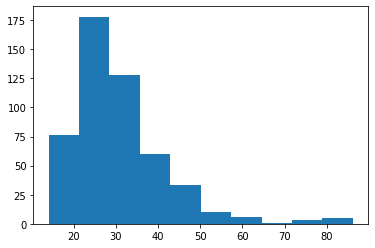

75% des images entrées ont une probabilité inférieure à 35.41
76% des images entrées ont une probabilité inférieure à 35.61
77% des images entrées ont une probabilité inférieure à 36.1
78% des images entrées ont une probabilité inférieure à 36.5
79% des images entrées ont une probabilité inférieure à 36.81
80% des images entrées ont une probabilité inférieure à 37.11
81% des images entrées ont une probabilité inférieure à 37.44
82% des images entrées ont une probabilité inférieure à 38.01
83% des images entrées ont une probabilité inférieure à 38.66
84% des images entrées ont une probabilité inférieure à 38.9
85% des images entrées ont une probabilité inférieure à 39.95
86% des images entrées ont une probabilité inférieure à 40.34
87% des images entrées ont une probabilité inférieure à 41.25
88% des images entrées ont une probabilité inférieure à 41.95
89% des images entrées ont une probabilité inférieure à 43.29
90% des images entrées ont une probabilité inférieure à 43.94
91% des ima

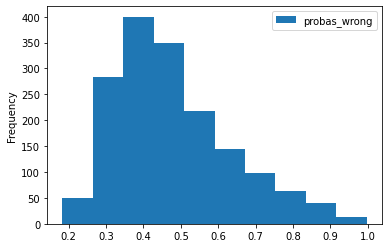


## Probabilités des prédictions vraies (notre modèle a raison)

Mean : 0.7924199528991673
Median : 0.87076247
Min : 0.20705205
Max : 0.9999839

77.67% des prédictions vraies sont au dessus de 0.6 de probabilité

76.67% des prédictions vraies sont au dessus de 0.61 de probabilité

75.67% des prédictions vraies sont au dessus de 0.62 de probabilité

74.78% des prédictions vraies sont au dessus de 0.63 de probabilité

73.82% des prédictions vraies sont au dessus de 0.64 de probabilité

72.86% des prédictions vraies sont au dessus de 0.65 de probabilité

72.12% des prédictions vraies sont au dessus de 0.66 de probabilité

71.19% des prédictions vraies sont au dessus de 0.67 de probabilité

70.21% des prédictions vraies sont au dessus de 0.68 de probabilité

68.99% des prédictions vraies sont au dessus de 0.69 de probabilité

67.96% des prédictions vraies sont au dessus de 0.7 de probabilité

67.07% des prédictions vraies sont au dessus de 0.71 de probabilité

66.35% des prédictions vraies

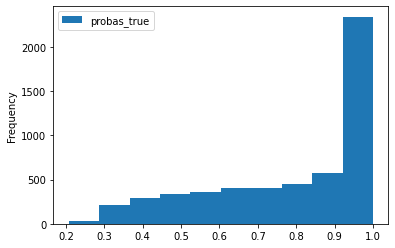


## Proportion des prédictions fausses selon le seuil haut choisi



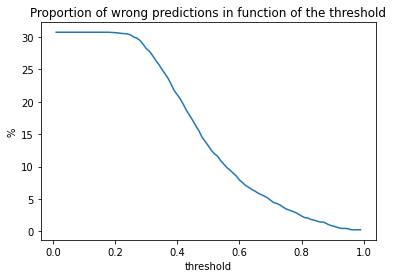



 Seuils trouvés : 0.371 - 0.67

______________________________________________________________________________



In [17]:
thresholds_search(model_name="EffB4_2022-03-02_08", images_as_urls=False, show_images=False, nb_test_images=500)

***Conditions***
- **Seuil bas**
    - Retirer environ 80% des mauvais exemples
    - Conserver environ 95% des bonnes prédictions
- **Seuil haut**
    - Ecarter environ 85% des prédictions fausses
    - Conserver environ 70% des bonnes prédictions

# **4. Recherche des seuils PAR CLASSE<a name='lookfor'/>**

## A) Charger la fonction

### **1) Seuil bas**

In [3]:
def low_threshold_per_class(MODEL_TORCH, INPUT_SIZE, loader, model_name, path_test_images=None, images_as_urls=True, nb_test_images=100, show_images=False):
    """ Recherche le seuil bas de Basegun pour chaque classe / typologie d'arme, qui dira que l'image donnée à Basegun n'est probablement pas une photo d'armes à feu
    Args:
        MODEL_TORCH (str): surnom du modèle choisi pour construire Basegun
        UNPUT_SIZE (int): taille de l'input associé au modèle choisi
        loader (transforms.Compose): permet de pre-process chaque image du dataset
        model_name (str): nom du modèle qui sera utilisé pour construire Basegun
        path_test_images (str): path vers des images random à utiliser pour trouver le seuil bas --facultatif--
        images_as_url (bool): le dataset à utiliser pour le seuil bas est Open Images (True car url d'images) ou DUTS (False)
        nb_test_images (int): nombre d'images à utiliser pour calculer le seuil bas 
        show_images (bool): affiche les images inférées pendant la recherche du seuil bas ainsi que leur propa calculée par Basegun
    Returns:
        possible_low (dict): dictionnaire contenant, pour chaque classe, plusieurs valeurs possibles de seuil bas et des infos relatives : elles permettront de choisir un meilleur seuil haut
    """    
    
    path_model = f"/workspace/models/{model_name}/{model_name}.pth"
    model = load_model_inference(path_model, MODEL_TORCH, INPUT_SIZE)
    probas = {key:[] for key in CLASSES}
    
    if not images_as_urls and path_test_images!=None: # just to make sure our progressbar will be have the good number of pins
        l = len(os.listdir(path_test_images))
        if nb_test_images > l:
            nb_test_images = l
            print(nb_test_images)
            
    if not show_images: # we do not plot the progressbar if the user wants the test images to be shown : because it would display in a bad way
        p = progressbar.ProgressBar(maxval=nb_test_images)

        
    if images_as_urls: # data is a set of url images (instead of .jpg files for example) from the openim.tsv
        path_test_images = "./openim.tsv"
        df = pd.read_csv(path_test_images, sep="\t", header=0, names=["url","c1","c2"])
        
        if not show_images:
            p.start()
            
        for i in range(nb_test_images):
            if not show_images:
                p.update(i)
                
            res = requests.get(df.url[i], stream=True)
            
            with open(f"./im{i}.jpg",'wb') as f:
                shutil.copyfileobj(res.raw,f)
                
            try:
                res = test_image(model, f"./im{i}.jpg", show_images, loader)
                if show_images:
                    print(res,"\n")
                probas[res[0]].append(res[1])
            except: 
                pass
            
            os.remove(f"./im{i}.jpg")
         
    else: # data is a folder containing .jpg files : for example DUTS
        if path_test_images == None: 
            path_test_images = "./DUTS-TR/DUTS-TR-Image"
        
        if not show_images:
            p.start()
            
        i=0
        for image in os.listdir(path_test_images):
            res = test_image(model, os.path.join(path_test_images,image), show_images, loader)
            if show_images:
                print(res,"\n")
            probas[res[0]].append(res[1])
            
            i+=1
            if not show_images: # we do not plot the progressbar if the user wants the images to be shown
                p.update(i)
            if i==nb_test_images:
                break
            
    possible_low = {key:{} for key in CLASSES}
    for c in probas.keys():
        '''
        plt.figure()
        plt.hist(sorted(probas[c]))
        plt.title(f"{c} : {len(probas[c])} prédictions")
        plt.xticks(np.arange(0,100,10))
        plt.show()
        '''
        try: # handles the case when len(probas[c]) == 0
            for i in np.arange(0.75,0.96,0.01):
                # print(f"{int(i*100)}% des images entrées ont une probabilité inférieure à {sorted(probas[c])[int(i*len(probas[c]))]}")
                possible_low[c][round(sorted(probas[c])[int(i*len(probas[c]))] / 100, 3)] = {"perc_wrong_examples_below": int(i*100), "perc_true_tests_over": None}
        except:
            print("Pas de prédictions pour cette classe")
    
    return possible_low

### **2) Seuil haut**

In [4]:
def high_threshold_per_class(model_name, possible_low, path_probas=None):    
    """ Recherche le seuil haut de Basegun pour chaque classe / typologie d'arme, qui dira que le résultat renvoyé par Basegun est à prendre avec des pincettes
    Args:
        model_name (str): nom du modèle qui sera utilisé pour construire Basegun
        possible_low (dict): dictionnaire contenant plusieurs valeurs possibles de seuil bas et des infos relatives : elles permettront de choisir un meilleur seuil haut
        path_probas (str): path vers le fichier csv des probabilités renvoyées par Basegun pour chaque donnée de train
    Returns:
        thresholds (dict): dictionnaire contenant, pour chaque classe, les seuils haut et bas associés
    """     
    
    if path_probas == None:
        path_probas = f"/workspace/models/{model_name}/probas_val.csv"
    df_all = pd.read_csv(path_probas)
    
    possible_high = {key:{} for key in CLASSES}
    thresholds = {key:[] for key in CLASSES}
    
    for c in possible_high.keys():
        
        l = list(possible_low[c].keys())
        if max(l) < 0.5:
            rangeHigh = np.arange(0.5,0.95,0.01)
        elif max(l) <= 0.98: 
            mini = max(l) + 0.01
            if max(l) > 0.85:
                maxi = 0.99
            else:
                maxi = 0.95
            rangeHigh = np.arange(mini,maxi,0.01)
        else:
            print(f"La valeur maximale possible du seuil bas est trop haute ({max(l)}) pour chercher un seuil haut.")
            break
        
        df = df_all[df_all.max_pred == c]
        # print('\n---------------',c,'---------------\n')

        # ---------- wrong predictions
        # print("## Probabilités des prédictions fausses (notre modèle a tort)\n")
        wrong = df[df.label != df.max_pred]
        probas_wrong =  wrong.select_dtypes(include=[float]).max(axis=1)
        wrong = pd.concat([probas_wrong,wrong], axis=1).rename(columns={0:"probas_wrong"})

        '''
        print(f"Mean : {np.mean(wrong.probas_wrong)}")
        print(f"Median : {np.median(wrong.probas_wrong)}")
        print(f"Min : {np.min(wrong.probas_wrong)}")
        print(f"Max : {np.max(wrong.probas_wrong)}")
        '''
         
        for p in rangeHigh:
            t = wrong[wrong.probas_wrong<p].probas_wrong.values
            perc = round(len(t)/len(list(wrong.probas_wrong))*100,2)
            possible_high[c][round(p,2)] = {"perc_wrong_tests_below": perc, "perc_true_tests_over": None}
            # print(f"\n{perc}% des prédictions fausses sont en dessous de {round(p,2)} de probabilité")
        
        '''
        ax1 = wrong.plot(y="probas_wrong",kind='hist')
        ax1.set_xticks(np.arange(0,1,0.1))
        plt.show()
        '''

        # ---------- true predictions
        # print("\n## Probabilités des prédictions vraies (notre modèle a raison)\n")
        true = df[df.label == df.max_pred]
        probas_true =  true.select_dtypes(include=[float]).max(axis=1)
        true = pd.concat([probas_true,true], axis=1).rename(columns={0:"probas_true"})

        '''        
        print(f"Mean : {np.mean(true.probas_true)}")
        print(f"Median : {np.median(true.probas_true)}")
        print(f"Min : {np.min(true.probas_true)}")
        print(f"Max : {np.max(true.probas_true)}")
        '''
                    
        l = list(possible_low[c].keys())
        l.extend(rangeHigh)

        for p in l:
            t = true[true.probas_true>p].probas_true.values
            perc = round(len(t)/len(list(true.probas_true))*100,2)

            if p in possible_low[c].keys():
                possible_low[c][p]["perc_true_tests_over"] = perc
            else:
                possible_high[c][round(p,2)]["perc_true_tests_over"] = perc
                # print(f"\n{perc}% des prédictions vraies sont au dessus de {round(p,2)} de probabilité")
        '''
        ax2 = true.plot(y="probas_true",kind='hist')
        ax2.set_xticks(np.arange(0,1,0.1))
        plt.show()
        '''
    
        for k in possible_high[c].keys():
            possible_high[c][k]["distance"] = round(sqrt(pow(possible_high[c][k]["perc_wrong_tests_below"] - 85, 2) + pow(possible_high[c][k]["perc_true_tests_over"] - 70, 2)), 3)  

        for k in possible_low[c].keys():
            possible_low[c][k]["distance"] = round(sqrt(pow(possible_low[c][k]["perc_wrong_examples_below"] - 80, 2) + pow(possible_low[c][k]["perc_true_tests_over"] - 95, 2)), 3)   

        #print("\nPossible Low :")
        #display(possible_low[c])

        thresholds[c].append(min(possible_low[c].items(),key = lambda i : i[1]["distance"])[0])

        #print("\nPossible High :")
        #display(possible_high[c])

        thresholds[c].append(min(possible_high[c].items(),key = lambda i : i[1]["distance"])[0])
    
    return thresholds

### **3) Fonction principale**

In [5]:
def thresholds_search_per_class(model_name, path_test_images=None, images_as_urls=False, nb_test_images=100, path_probas=None, show_images=False):
    """ Recherche les seuils haut et bas de Basegun pour chaque classe / typologie d'arme, qui permettront d'écarter les cas où l'indice de fiabilité est trop faible
    Args:
        model_name (str): nom du modèle qui sera utilisé pour construire Basegun
        path_test_images (str): path vers des images random à utiliser pour trouver le seuil bas --facultatif--
        images_as_url (bool): le dataset à utiliser pour le seuil bas est Open Images (True car url d'images) ou DUTS (False)
        nb_test_images (int): nombre d'images à utiliser pour calculer le seuil bas 
        path_probas (str): path vers le fichier csv des probabilités renvoyées par Basegun pour chaque donnée de train
        show_images (bool): affiche les images inférées pendant la recherche du seuil bas ainsi que leur propa calculée par Basegun
    Returns:
        low (float)
        high (float)
    """    
    
    NETS = {
        'EffB0': {'input_size': 224, 'model': Model.efficientnet_b0},
        'EffB1': {'input_size': 240, 'model': Model.efficientnet_b1},
        'EffB2': {'input_size': 288, 'model': Model.efficientnet_b2},
        'EffB3': {'input_size': 300, 'model': Model.efficientnet_b3},
        'EffB4': {'input_size': 380, 'model': Model.efficientnet_b4},
        'EffB5': {'input_size': 456, 'model': Model.efficientnet_b5},
        'B5': {'input_size': 456, 'model': Model.efficientnet_b5},
        'EffB6': {'input_size': 528, 'model': Model.efficientnet_b6},
        'EffB7': {'input_size': 600, 'model': Model.efficientnet_b7},
        'Res18': {'input_size': 224, 'model': Model.resnet18},
        'Dense169': {'input_size': 224, 'model': Model.densenet169},
        'Dense201': {'input_size': 224, 'model': Model.densenet201}
        }

    MODEL_TORCH = None
    INPUT_SIZE = None
    for k in NETS.keys():
        if k in model_name:
            MODEL_TORCH = NETS[k]['model']
            INPUT_SIZE = NETS[k]['input_size']
            break
                
    if MODEL_TORCH == None:
        print("WARNING : No model was found during initialization. Check for thresholds_search() function and NETS variable.\nEfficientNet B7 was chosen by default.")
        MODEL_TORCH = NETS['EffB7']['model']
        INPUT_SIZE = NETS['EffB7']['input_size']

    loader =  transforms.Compose([
                ConvertRgb(),
                Rescale(INPUT_SIZE),
                RandomPad(INPUT_SIZE),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

    
    #print("------------------------------------------------------------------------------\n\n# 1. Seuil Bas\n")
    possible_low = low_threshold_per_class(MODEL_TORCH, INPUT_SIZE, loader, model_name, path_test_images, images_as_urls, nb_test_images, show_images)
    
    #print("\n------------------------------------------------------------------------------\n\n,# 2. Seuil Haut\n")
    thresholds = high_threshold_per_class(model_name, possible_low, path_probas)

    #thresholds = dict(sorted(thresholds.items(), key=lambda i:i[1][1]))

    meanLow = np.mean([el[0] for el in list(thresholds.values())])
    meanHigh = np.mean([el[1] for el in list(thresholds.values())])
            
    df = pd.DataFrame(thresholds, index=["Bas","Haut"], columns=CLASSES).transpose()
    df.sort_values(by=['Haut'], inplace=True)
    display(df)
    
    #df.plot(kind='bar', figsize=(30,15), color=['blue','plum'], stacked=True)
    
    fig, ax = plt.subplots(figsize=(30, 15))
    ax.bar(df.index, df['Bas'], label='Bas', color='blue')
    ax.bar(df.index, df['Haut'], alpha=0.5, label='Haut', color='plum')
    
    rectsLow = ax.patches[:10]
    rectsHigh = ax.patches[10:]
    labelsLow = df.Bas.values
    labelsHigh = df.Haut.values
    
    for rect, label in zip(rectsLow, labelsLow):
        ax.text(rect.get_x() + rect.get_width() / 2., rect.get_height(), label, ha='center', va='bottom', color='g', size=15)
    for rect, label in zip(rectsHigh, labelsHigh):
        ax.text(rect.get_x() + rect.get_width() / 2., rect.get_height(), label, ha='center', va='bottom', color='r', size=15)

    plt.xticks(fontsize='xx-large', rotation=45)
    l1 = ax.axhline(y=meanLow, color='green', ls='--', lw=3)
    l2 = ax.axhline(y=meanHigh, color='red', ls='--', lw=3)
    
    ax.text(-1.25, l1.get_ydata()[0], round(l1.get_ydata()[0],3), ha='left', va='bottom', color='black', size=15)
    ax.text(-1.25, l2.get_ydata()[0], round(l2.get_ydata()[0],3), ha='left', va='bottom', color='black', size=15)

    plt.show()
    
    print("\n______________________________________________________________________________\n")  

## B) Lancer l'analyse <a name='go'/>

- Entrez le nom du modèle et le nombre d'images à tester 
    - 0.10 à 0.7 sec/image pour le DUTS dataset <-> *images_as_urls=False*
    - 1.2 sec/image pour le Open Images dataset <-> *images_as_urls=True*

    
- Remarque : Le temps dépend notamment du modèle choisi (EffB4 2 fois plus rapide que EffB7)


- Vous pouvez aussi **utiliser votre propre dataset** (dossier contenant des photos au format **JPG** uniquement) en renseignant son chemin d'accès dans la variable *path_test_images*

- Pour afficher l'image à chaque test ainsi que le score prédit par le modèle : *show_images=True* (déconseillé si grand nombre d'images de test)

,Bas,Haut
epaule_a_levier_sous_garde,0.385,0.62
epaule_a_verrou,0.399,0.62
epaule_a_un_coup,0.474,0.66
autre_epaule,0.389,0.67
epaule_a_pompe,0.401,0.69
epaule_a_percussion_silex,0.400,0.71
autre_pistolet,0.492,0.84
pistolet_semi_auto_moderne,0.653,0.94
revolver,0.514,0.94
pistolet_a_percussion_silex,0.642,0.95


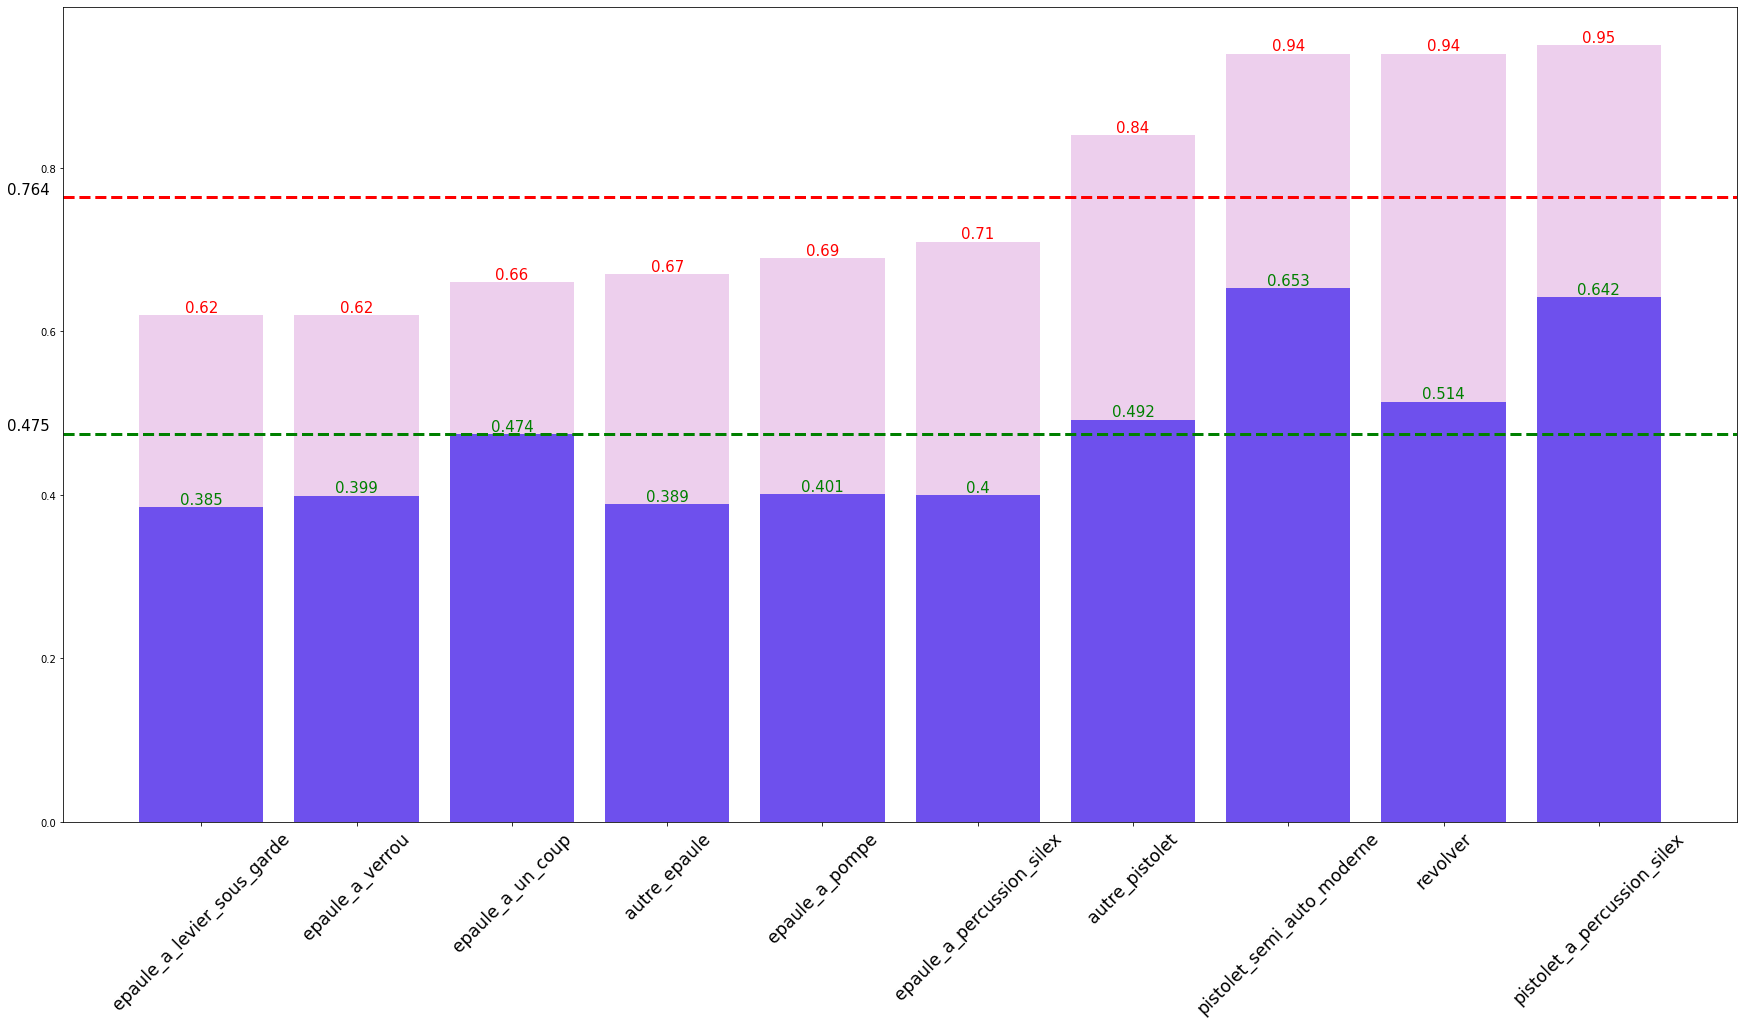


______________________________________________________________________________



In [8]:
thresholds_search_per_class(model_name="EffB7_2022-03-01_17", images_as_urls=False, show_images=False, nb_test_images=1000)

***Conditions***
- **Seuil bas**
    - Retirer environ 80% des mauvais exemples
    - Conserver environ 95% des bonnes prédictions
- **Seuil haut**
    - Ecarter environ 85% des prédictions fausses
    - Conserver environ 70% des bonnes prédictions